In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import TensorBoard
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import backend as K

# Dataset Preperation

Preprocess

In [2]:
test_dataset = np.load('./kdd99_dataset_FINAL_test.npy', mmap_mode="r")

In [3]:
uniqued_dataset_2 = np.load('./kdd99_dataset_FINAL.npy', mmap_mode="r")

In [4]:
uniqued_dataset_2 = np.around(uniqued_dataset_2, 2)
uniqued_dataset_2 = np.unique(uniqued_dataset_2, axis=0)
test_dataset = np.around(test_dataset, 2)
test_dataset = np.unique(test_dataset, axis=0)

In [5]:
dataset = uniqued_dataset_2

In [6]:
dataset_labels = dataset[:, 117:]

In [7]:
dataset_without_label = dataset[:, :117]

### TRACE

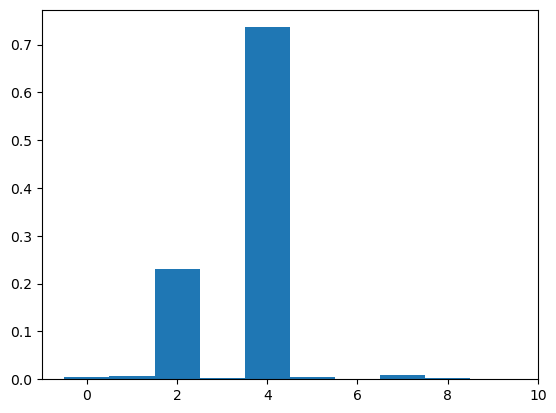

In [8]:
y_tr_idx = dataset_labels[:, :].argmax(axis=1)
class_density = plt.hist(y_tr_idx, bins=10, range=(-0.5, 9.5), density=True)[0]
# class_weights = 1 / class_density
# class_weights = class_weights / np.max(class_weights)

In [9]:
test_dataset[:, [3, 4]] = test_dataset[:, [4, 3]]

In [10]:
args = np.argmax(dataset_labels, axis=1)
mask = np.logical_or(np.logical_or(args<2, np.logical_and(args<6, args>3)), args==5)
# mask = np.logical_or(args<=2, np.logical_and(args<6, args>3))

args2 = np.argmax(test_dataset, axis=1)
mask2 = np.logical_and(args2<5, args2>=0)
# mask2 = np.logical_or(args2<=2, np.logical_and(args2<6, args2>3))

In [11]:
args[mask]

array([4, 4, 4, ..., 4, 5, 1], dtype=int64)

In [12]:
dataset_labels = dataset_labels[mask, ...]
dataset_without_label = dataset_without_label[mask, ...]
test_dataset = test_dataset[mask2, ...]

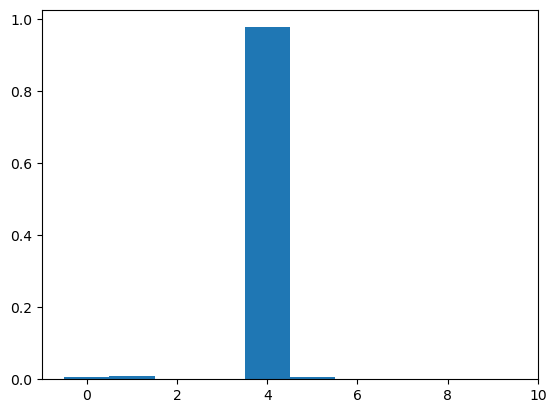

In [13]:
y_tr_idx2 = dataset_labels[:, :].argmax(axis=1)
class_density = plt.hist(y_tr_idx2, bins=10, range=(-0.5, 9.5), density=True)[0]
# class_weights = 1 / class_density
# class_weights = class_weights / np.max(class_weights)

# Model

In [14]:
input_layer = keras.Input((117,))
H1 = layers.Dense(32, activation='sigmoid')
H2 = layers.Dense(32, activation='sigmoid')
H3 = layers.Dense(32, activation='sigmoid')
H4 = layers.Dense(32, activation='sigmoid')
supervised_layer = layers.Dense(5, activation='sigmoid')
output_layer = layers.Dense(5, activation='softmax')

### AutoEncoder 1

In [15]:
encoded1 = H1(input_layer)
decoded1 = layers.Dense(117,)(encoded1)
auto_encoder1 = keras.Model(input_layer, decoded1)
auto_encoder1.compile(loss="mse", metrics=["mse", 'mae'], weighted_metrics=["mse", 'mae'])
auto_encoder1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 117)]             0         
                                                                 
 dense (Dense)               (None, 32)                3776      
                                                                 
 dense_6 (Dense)             (None, 117)               3861      
                                                                 
Total params: 7,637
Trainable params: 7,637
Non-trainable params: 0
_________________________________________________________________


In [16]:
only_encoded1 = keras.Model(input_layer, encoded1)
only_encoded1.compile(loss="mse")

### AutoEncoder 2

In [17]:
encoded2 = H2(encoded1)
decoded2 = layers.Dense(32,)(encoded2)
auto_encoder2 = keras.Model(encoded1, decoded2)
auto_encoder2.compile(loss="mse", metrics=["mse", 'mae'], weighted_metrics=["mse", 'mae'])
# auto_encoder2.summary()

In [18]:
only_encoded2 = keras.Model(input_layer, encoded2)
only_encoded2.compile(loss="mse", metrics=["mae"])

### AutoEncoder 3

In [19]:
encoded3 = H3(encoded2)
decoded3 = layers.Dense(32,)(encoded3)
auto_encoder3 = keras.Model(encoded2, decoded3)
auto_encoder3.compile(loss="mse", metrics=["mse", 'mae'], weighted_metrics=["mse", 'mae'])
# auto_encoder3.summary()

In [20]:
only_encoded3 = keras.Model(input_layer, encoded3)
only_encoded3.compile(loss="mse", metrics=["mae"])

### AutoEncoder 4

In [21]:
encoded4 = H4(encoded3)
decoded4 = layers.Dense(32,)(encoded4)
auto_encoder4 = keras.Model(encoded3, decoded4)
auto_encoder4.compile(loss="mse", metrics=["mse", 'mae'], weighted_metrics=["mse", 'mae'])
# auto_encoder4.summary()

In [22]:
only_encoded4 = keras.Model(input_layer, encoded4)
only_encoded4.compile(loss="mse", metrics=["mae"])

### Supervised Layer

In [23]:
temp_ = supervised_layer(encoded4)
out__ = output_layer(temp_)
supervised_part = keras.Model(encoded4, out__)
supervised_part.compile(loss='categorical_crossentropy', weighted_metrics=['accuracy', 'categorical_crossentropy'],
                         metrics=['accuracy', 'categorical_crossentropy'])

### Full Assembly of the Model

In [24]:
temp = supervised_layer(encoded4)
out_ = output_layer(temp)
final_supervised = keras.Model(input_layer, out_)
final_supervised.compile(loss='categorical_crossentropy', weighted_metrics=['accuracy', 'categorical_crossentropy'],
                         metrics=['accuracy', 'categorical_crossentropy', tf.keras.metrics.TruePositives(
    thresholds=None, name=None, dtype=None
), tf.keras.metrics.FalseNegatives(
    thresholds=None, name=None, dtype=None
), tf.keras.metrics.TrueNegatives(
    thresholds=None, name=None, dtype=None
), tf.keras.metrics.FalsePositives(
    thresholds=None, name=None, dtype=None
)])
K.set_value(final_supervised.optimizer.learning_rate, 0.001)

# Training

In [25]:
for i in range(100):
    results = final_supervised.evaluate(dataset_without_label, dataset_labels[:, :5], batch_size=128)[1]
    if (results >= 0.99):
        break
    final_supervised.fit(dataset_without_label, dataset_labels[:, :5],
            epochs=1, batch_size=128,
            shuffle=False, validation_data=None,
            callbacks=[TensorBoard(log_dir='/tmp/final_supervised')])

2688/2688 [==============================] - 3s 1ms/step - loss: 0.1320 - accuracy: 0.9769 - categorical_crossentropy: 0.1320 - true_positives: 335986.0000 - false_negatives: 6110.0000 - true_negatives: 1369670.0000 - false_positives: 7959.0000 - weighted_accuracy: 0.9769 - weighted_categorical_crossentropy: 0.1320


KeyboardInterrupt: 

In [ ]:
final_supervised.save("./final_supervised_")

# Evaluation

In [ ]:
test_dataset_without_labels = test_dataset[:, :117]
test_dataset_labels = test_dataset[:, 117:]
print("Evaluate on test data")
results = final_supervised.evaluate(test_dataset_without_labels, test_dataset_labels[:, :5], batch_size=12)
print("test loss, test acc:", results)

In [ ]:
print("Evaluate on train data")
results = final_supervised.evaluate(dataset_without_label, dataset_labels[:, :5], batch_size=128)
print(results)

# Confusion Matrix

In [ ]:
y_hat_tr = final_supervised(dataset_without_label)
y_hat_tr_idx = np.array(y_hat_tr).argmax(axis=1)
y_tr_idx = dataset_labels.argmax(axis=1)

In [33]:
conf = np.zeros((10, 10), dtype=np.int32)
print(y_tr_idx.shape[0])
for i in tqdm(range(y_tr_idx.shape[0] // 250)):
    conf[y_tr_idx, y_hat_tr_idx] += 1

343945


100%|█████████████████████████████████████████████████████████████████████████████| 1375/1375 [00:04<00:00, 303.95it/s]


<Figure size 1000x1000 with 0 Axes>

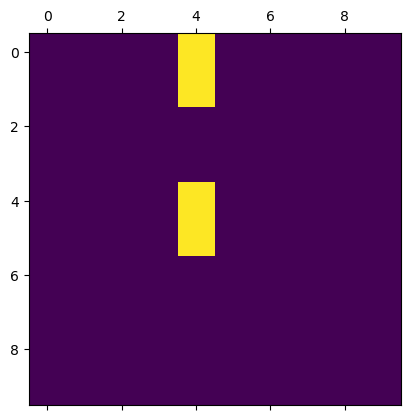

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.matshow(conf)
plt.show()